# Data Augmentation
Courtesy of https://github.com/EBjerrum/SMILES-enumeration/blob/master/SmilesEnumerator.py
From this paper https://arxiv.org/pdf/1703.07076
Mentioned in ChemBerta https://arxiv.org/pdf/2010.09885


In [1]:
#Experimental Class for Smiles Enumeration, Iterator and SmilesIterator adapted from Keras 1.2.2
from rdkit import Chem
import numpy as np
import threading

class Iterator(object):
    """Abstract base class for data iterators.

    # Arguments
        n: Integer, total number of samples in the dataset to loop over.
        batch_size: Integer, size of a batch.
        shuffle: Boolean, whether to shuffle the data between epochs.
        seed: Random seeding for data shuffling.
    """

    def __init__(self, n, batch_size, shuffle, seed):
        self.n = n
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.batch_index = 0
        self.total_batches_seen = 0
        self.lock = threading.Lock()
        self.index_generator = self._flow_index(n, batch_size, shuffle, seed)
        if n < batch_size:
            raise ValueError('Input data length is shorter than batch_size\nAdjust batch_size')

    def reset(self):
        self.batch_index = 0

    def _flow_index(self, n, batch_size=32, shuffle=False, seed=None):
        # Ensure self.batch_index is 0.
        self.reset()
        while 1:
            if seed is not None:
                np.random.seed(seed + self.total_batches_seen)
            if self.batch_index == 0:
                index_array = np.arange(n)
                if shuffle:
                    index_array = np.random.permutation(n)

            current_index = (self.batch_index * batch_size) % n
            if n > current_index + batch_size:
                current_batch_size = batch_size
                self.batch_index += 1
            else:
                current_batch_size = n - current_index
                self.batch_index = 0
            self.total_batches_seen += 1
            yield (index_array[current_index: current_index + current_batch_size],
                   current_index, current_batch_size)

    def __iter__(self):
        # Needed if we want to do something like:
        # for x, y in data_gen.flow(...):
        return self

    def __next__(self, *args, **kwargs):
        return self.next(*args, **kwargs)




class SmilesIterator(Iterator):
    """Iterator yielding data from a SMILES array.

    # Arguments
        x: Numpy array of SMILES input data.
        y: Numpy array of targets data.
        smiles_data_generator: Instance of `SmilesEnumerator`
            to use for random SMILES generation.
        batch_size: Integer, size of a batch.
        shuffle: Boolean, whether to shuffle the data between epochs.
        seed: Random seed for data shuffling.
        dtype: dtype to use for returned batch. Set to keras.backend.floatx if using Keras
    """

    def __init__(self, x, y, smiles_data_generator,
                 batch_size=32, shuffle=False, seed=None,
                 dtype=np.float32
                 ):
        if y is not None and len(x) != len(y):
            raise ValueError('X (images tensor) and y (labels) '
                             'should have the same length. '
                             'Found: X.shape = %s, y.shape = %s' %
                             (np.asarray(x).shape, np.asarray(y).shape))

        self.x = np.asarray(x)

        if y is not None:
            self.y = np.asarray(y)
        else:
            self.y = None
        self.smiles_data_generator = smiles_data_generator
        self.dtype = dtype
        super(SmilesIterator, self).__init__(x.shape[0], batch_size, shuffle, seed)

    def next(self):
        """For python 2.x.

        # Returns
            The next batch.
        """
        # Keeps under lock only the mechanism which advances
        # the indexing of each batch.
        with self.lock:
            index_array, current_index, current_batch_size = next(self.index_generator)
        # The transformation of images is not under thread lock
        # so it can be done in parallel
        batch_x = np.zeros(tuple([current_batch_size] + [ self.smiles_data_generator.pad, self.smiles_data_generator._charlen]), dtype=self.dtype)
        for i, j in enumerate(index_array):
            smiles = self.x[j:j+1]
            x = self.smiles_data_generator.transform(smiles)
            batch_x[i] = x

        if self.y is None:
            return batch_x
        batch_y = self.y[index_array]
        return batch_x, batch_y


class SmilesEnumerator(object):
    """SMILES Enumerator, vectorizer and devectorizer
    
    #Arguments
        charset: string containing the characters for the vectorization
          can also be generated via the .fit() method
        pad: Length of the vectorization
        leftpad: Add spaces to the left of the SMILES
        isomericSmiles: Generate SMILES containing information about stereogenic centers
        enum: Enumerate the SMILES during transform
        canonical: use canonical SMILES during transform (overrides enum)
    """
    def __init__(self, charset = '@C)(=cOn1S2/H[N]\\', pad=120, leftpad=True, isomericSmiles=True, enum=True, canonical=False):
        self._charset = None
        self.charset = charset
        self.pad = pad
        self.leftpad = leftpad
        self.isomericSmiles = isomericSmiles
        self.enumerate = enum
        self.canonical = canonical

    @property
    def charset(self):
        return self._charset
        
    @charset.setter
    def charset(self, charset):
        self._charset = charset
        self._charlen = len(charset)
        self._char_to_int = dict((c,i) for i,c in enumerate(charset))
        self._int_to_char = dict((i,c) for i,c in enumerate(charset))
        
    def fit(self, smiles, extra_chars=[], extra_pad = 5):
        """Performs extraction of the charset and length of a SMILES datasets and sets self.pad and self.charset
        
        #Arguments
            smiles: Numpy array or Pandas series containing smiles as strings
            extra_chars: List of extra chars to add to the charset (e.g. "\\\\" when "/" is present)
            extra_pad: Extra padding to add before or after the SMILES vectorization
        """
        charset = set("".join(list(smiles)))
        self.charset = "".join(charset.union(set(extra_chars)))
        self.pad = max([len(smile) for smile in smiles]) + extra_pad
        
    def randomize_smiles(self, smiles):
        """Perform a randomization of a SMILES string
        must be RDKit sanitizable"""
        m = Chem.MolFromSmiles(smiles)
        ans = list(range(m.GetNumAtoms()))
        np.random.shuffle(ans)
        nm = Chem.RenumberAtoms(m,ans)
        return Chem.MolToSmiles(nm, canonical=self.canonical, isomericSmiles=self.isomericSmiles)

    def transform(self, smiles):
        """Perform an enumeration (randomization) and vectorization of a Numpy array of smiles strings
        #Arguments
            smiles: Numpy array or Pandas series containing smiles as strings
        """
        one_hot =  np.zeros((smiles.shape[0], self.pad, self._charlen),dtype=np.int8)
        
        if self.leftpad:
            for i,ss in enumerate(smiles):
                if self.enumerate: ss = self.randomize_smiles(ss)
                l = len(ss)
                diff = self.pad - l
                for j,c in enumerate(ss):
                    one_hot[i,j+diff,self._char_to_int[c]] = 1
            return one_hot
        else:
            for i,ss in enumerate(smiles):
                if self.enumerate: ss = self.randomize_smiles(ss)
                for j,c in enumerate(ss):
                    one_hot[i,j,self._char_to_int[c]] = 1
            return one_hot

      
    def reverse_transform(self, vect):
        """ Performs a conversion of a vectorized SMILES to a smiles strings
        charset must be the same as used for vectorization.
        #Arguments
            vect: Numpy array of vectorized SMILES.
        """       
        smiles = []
        for v in vect:
            #mask v 
            v=v[v.sum(axis=1)==1]
            #Find one hot encoded index with argmax, translate to char and join to string
            smile = "".join(self._int_to_char[i] for i in v.argmax(axis=1))
            smiles.append(smile)
        return np.array(smiles)
     
if __name__ == "__main__":
    smiles = np.array([ "CCC(=O)O[C@@]1(CC[NH+](C[C@H]1CC=C)C)c2ccccc2",
                        "CCC[S@@](=O)c1ccc2c(c1)[nH]/c(=N/C(=O)OC)/[nH]2"]*10
                        )
    #Test canonical SMILES vectorization
    sm_en = SmilesEnumerator(canonical=True, enum=False)
    sm_en.fit(smiles, extra_chars=["\\"])
    v = sm_en.transform(smiles)
    transformed = sm_en.reverse_transform(v)
    if len(set(transformed)) > 2: print("Too many different canonical SMILES generated")
    
    #Test enumeration 
    sm_en.canonical = False
    sm_en.enumerate = True
    v2 = sm_en.transform(smiles)
    transformed = sm_en.reverse_transform(v2)
    if len(set(transformed)) < 3: print("Too few enumerated SMILES generated")

    #Reconstruction
    reconstructed = sm_en.reverse_transform(v[0:5])
    for i, smile in enumerate(reconstructed):
        if smile != smiles[i]:
            print("Error in reconstruction %s %s"%(smile, smiles[i]))
            break
    
    #test Pandas
    import pandas as pd
    df = pd.DataFrame(smiles)
    v = sm_en.transform(df[0])
    if v.shape != (20, 52, 18): print("Possible error in pandas use")
    
    #BUG, when batchsize > x.shape[0], then it only returns x.shape[0]!
    #Test batch generation
    sm_it = SmilesIterator(smiles, np.array([1,2]*10), sm_en, batch_size=10, shuffle=True)
    X, y = sm_it.next()
    if sum(y==1) - sum(y==2) > 1:
        print("Unbalanced generation of batches")
    if len(X) != 10: print("Error in batchsize generation")



        

In [2]:
sme = SmilesEnumerator()

Check that this works.

In [3]:
for i in range(10):
    print(sme.randomize_smiles("CCC"))

CCC
CCC
C(C)C
C(C)C
CCC
CCC
CCC
C(C)C
C(C)C
CCC


For a random number like 10, we may see a lot of duplication

In [4]:
new_dict = {}
for i in range(100):
    new_dict[sme.randomize_smiles("CCC")] = True
print(list(new_dict.keys()))

['CCC', 'C(C)C']


In [5]:
new_dict = {}
for i in range(100):
    new_dict[sme.randomize_smiles("Cc1ccccc1")] = True
print(list(new_dict.keys()))

['c1cc(C)ccc1', 'Cc1ccccc1', 'c1c(C)cccc1', 'c1cccc(C)c1', 'c1(C)ccccc1', 'c1ccccc1C', 'c1ccc(C)cc1']


Check if anything went wrong here then add SWA
https://www.jmlr.org/papers/v25/21-1125.html

In [12]:
import datamol as dm
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback, get_linear_schedule_with_warmup
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from copy import deepcopy
from torch.utils.data import DataLoader
from transformers import AutoModelForSequenceClassification, AdamW
from torch.optim.swa_utils import AveragedModel, SWALR, update_bn
from tqdm import tqdm


# Load the ChemBERTa model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModelForSequenceClassification.from_pretrained("seyonec/ChemBERTa-zinc-base-v1", num_labels=1)
model.to(device) 

# Load the data
df = dm.data.freesolv()
X, y = df["smiles"], df["expt"]

# Tokenize the SMILES strings
def tokenize_function(smiles):
    return tokenizer(smiles, padding="max_length", truncation=True, max_length=128)

# Convert the tokenized data to the format required by Hugging Face
class FreeSolvDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.float)
        return item

    def __len__(self):
        return len(self.labels)

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Data augmentation: Randomize SMILES strings
new_X, new_Y = [], []

for idx in X_train.index:
    new_dict = {}
    for j in range(100):
        new_dict[sme.randomize_smiles(X_train.loc[idx])] = True
    new_x = list(new_dict.keys())
    new_y = [y_train.loc[idx]] * len(new_x)
#     print(idx)
#     print(new_x)
#     print(new_y)
    new_X.extend(new_x)
    new_Y.extend(new_y)

# Convert new_X and new_Y to DataFrame or Series if needed
X_train = pd.Series(new_X).squeeze()
y_train = pd.Series(new_Y).squeeze()

# Convert augmented data to DataFrame and Series
# X_train = pd.DataFrame(new_X).squeeze()
# y_train = pd.DataFrame(new_Y).squeeze()

# Tokenize the datasets
print("Tokenizing datasets...")
train_encodings = tokenizer(list(X_train), padding=True, truncation=True, max_length=128, return_tensors="pt")
val_encodings = tokenizer(list(X_val), padding=True, truncation=True, max_length=128, return_tensors="pt")
test_encodings = tokenizer(list(X_test), padding=True, truncation=True, max_length=128, return_tensors="pt")


# Create the datasets
class FreeSolvDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.float).clone().detach()
        return item

    def __len__(self):
        return len(self.labels)

print("Creating datasets...")
train_dataset = FreeSolvDataset(train_encodings, y_train.values)
val_dataset = FreeSolvDataset(val_encodings, y_val.values)
test_dataset = FreeSolvDataset(test_encodings, y_test.values)

# Create DataLoader for batching
print("Creating DataLoader for batching...")
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1024)
test_loader = DataLoader(test_dataset, batch_size=1024)

# Create the optimizer and learning rate scheduler
print("Creating optimizer and learning rate scheduler...")
optimizer = AdamW(model.parameters(), lr=3e-4, weight_decay=0.03)

# Custom learning rate scheduler function
def lr_lambda(epoch):
    if epoch < 20:
        return 1 - (epoch / 10) * 0.5  # Decay by a factor of 2
    else:
        return 0.5  # Remain flat

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

# Initialize SWA
print("Initializing SWA...")
swa_model = AveragedModel(model)
swa_start = 20
swa_scheduler = SWALR(optimizer, swa_lr=1e-4)

# Early stopping variables
best_val_loss = float('inf')
best_swa_eval_loss = float('inf')
patience = 5
epochs_no_improve = 0
best_model_state = None
best_swa_model_state = None

# Training loop
print("Starting training loop...")
for epoch in range(200):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}"):
        optimizer.zero_grad()
        inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
        labels = batch['labels'].to(device)
        outputs = model(**inputs, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        scheduler.step()
        total_loss += loss.item()
    
    print(f"Epoch {epoch + 1} - Training Loss: {total_loss / len(train_loader)}")

    model.eval()
    eval_loss = 0
    for batch in tqdm(val_loader, desc=f"Validation Epoch {epoch + 1}"):
        with torch.no_grad():
            inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
            labels = batch['labels'].to(device)
            outputs = model(**inputs, labels=labels)
            loss = outputs.loss
            eval_loss += loss.item()
    
    eval_loss /= len(val_loader)
    print(f"Epoch {epoch + 1} - Validation Loss: {eval_loss}")

    swa_eval_loss = None
    if epoch >= swa_start:
        swa_model.update_parameters(model)
        swa_scheduler.step()
        update_bn(train_loader, swa_model)
        swa_eval_loss = 0
        for batch in tqdm(val_loader, desc=f"SWA Validation Epoch {epoch + 1}"):
            with torch.no_grad():
                inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
                labels = batch['labels'].to(device)
                outputs = swa_model(**inputs, labels=labels)
                loss = outputs.loss
                swa_eval_loss += loss.item()
        
        swa_eval_loss /= len(val_loader)
        print(f"SWA Model Evaluation after epoch {epoch + 1} - Validation Loss: {swa_eval_loss}")

        # Check for early stopping and best model state after SWA has started
        if swa_eval_loss < best_swa_eval_loss:
            best_swa_eval_loss = swa_eval_loss
            best_swa_model_state = swa_model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print("Early stopping due to no improvement in SWA validation loss.")
            break

    # Check for best model state based on validation loss
    if eval_loss < best_val_loss:
        best_val_loss = eval_loss
        best_model_state = model.state_dict()

# Load the best model state
if best_swa_model_state is not None and best_swa_eval_loss < best_val_loss:
    print("Loading the best SWA model state...")
    swa_model.load_state_dict(best_swa_model_state)
    model = swa_model
else:
    print("Loading the best model state...")
    model.load_state_dict(best_model_state)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at seyonec/ChemBERTa-zinc-base-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Tokenizing datasets...
Creating datasets...
Creating DataLoader for batching...


/home/diegog/anaconda3/lib/python3.11/site-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Creating optimizer and learning rate scheduler...
Initializing SWA...
Starting training loop...


Training Epoch 1: 100%|██████████████████████████████████████████████████████████████████████████| 8/8 [00:09<00:00,  1.14s/it]


Epoch 1 - Training Loss: 13.87985622882843


Validation Epoch 1: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.09it/s]


Epoch 1 - Validation Loss: 15.216232299804688


Training Epoch 2: 100%|██████████████████████████████████████████████████████████████████████████| 8/8 [00:09<00:00,  1.13s/it]


Epoch 2 - Training Loss: 5.415182173252106


Validation Epoch 2: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.17it/s]


Epoch 2 - Validation Loss: 11.005816459655762


Training Epoch 3: 100%|██████████████████████████████████████████████████████████████████████████| 8/8 [00:09<00:00,  1.14s/it]


Epoch 3 - Training Loss: 3.9532554149627686


Validation Epoch 3: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.13it/s]


Epoch 3 - Validation Loss: 9.935976028442383


Training Epoch 4: 100%|██████████████████████████████████████████████████████████████████████████| 8/8 [00:09<00:00,  1.14s/it]


Epoch 4 - Training Loss: 2.689452350139618


Validation Epoch 4: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.92it/s]


Epoch 4 - Validation Loss: 9.269729614257812


Training Epoch 5: 100%|██████████████████████████████████████████████████████████████████████████| 8/8 [00:09<00:00,  1.14s/it]


Epoch 5 - Training Loss: 1.839014858007431


Validation Epoch 5: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.90it/s]


Epoch 5 - Validation Loss: 8.211661338806152


Training Epoch 6: 100%|██████████████████████████████████████████████████████████████████████████| 8/8 [00:09<00:00,  1.16s/it]


Epoch 6 - Training Loss: 1.396876722574234


Validation Epoch 6: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.93it/s]


Epoch 6 - Validation Loss: 7.393630027770996


Training Epoch 7: 100%|██████████████████████████████████████████████████████████████████████████| 8/8 [00:09<00:00,  1.15s/it]


Epoch 7 - Training Loss: 1.110136330127716


Validation Epoch 7: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.25it/s]


Epoch 7 - Validation Loss: 6.809459209442139


Training Epoch 8: 100%|██████████████████████████████████████████████████████████████████████████| 8/8 [00:09<00:00,  1.15s/it]


Epoch 8 - Training Loss: 0.8839591890573502


Validation Epoch 8: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.81it/s]


Epoch 8 - Validation Loss: 6.591165542602539


Training Epoch 9: 100%|██████████████████████████████████████████████████████████████████████████| 8/8 [00:09<00:00,  1.15s/it]


Epoch 9 - Training Loss: 0.7550819590687752


Validation Epoch 9: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.93it/s]


Epoch 9 - Validation Loss: 6.2249956130981445


Training Epoch 10: 100%|█████████████████████████████████████████████████████████████████████████| 8/8 [00:09<00:00,  1.15s/it]


Epoch 10 - Training Loss: 0.6315258033573627


Validation Epoch 10: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.79it/s]


Epoch 10 - Validation Loss: 6.092299938201904


Training Epoch 11: 100%|█████████████████████████████████████████████████████████████████████████| 8/8 [00:09<00:00,  1.15s/it]


Epoch 11 - Training Loss: 0.5691409856081009


Validation Epoch 11: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.79it/s]


Epoch 11 - Validation Loss: 5.885162353515625


Training Epoch 12: 100%|█████████████████████████████████████████████████████████████████████████| 8/8 [00:09<00:00,  1.15s/it]


Epoch 12 - Training Loss: 0.5078592039644718


Validation Epoch 12: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.93it/s]


Epoch 12 - Validation Loss: 5.979198455810547


Training Epoch 13: 100%|█████████████████████████████████████████████████████████████████████████| 8/8 [00:09<00:00,  1.15s/it]


Epoch 13 - Training Loss: 0.46816687658429146


Validation Epoch 13: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.96it/s]


Epoch 13 - Validation Loss: 5.912832260131836


Training Epoch 14: 100%|█████████████████████████████████████████████████████████████████████████| 8/8 [00:09<00:00,  1.15s/it]


Epoch 14 - Training Loss: 0.4487992152571678


Validation Epoch 14: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.78it/s]


Epoch 14 - Validation Loss: 6.110393524169922


Training Epoch 15: 100%|█████████████████████████████████████████████████████████████████████████| 8/8 [00:09<00:00,  1.15s/it]


Epoch 15 - Training Loss: 0.40387191250920296


Validation Epoch 15: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.86it/s]


Epoch 15 - Validation Loss: 6.054356098175049


Training Epoch 16: 100%|█████████████████████████████████████████████████████████████████████████| 8/8 [00:09<00:00,  1.15s/it]


Epoch 16 - Training Loss: 0.3568425290286541


Validation Epoch 16: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.08it/s]


Epoch 16 - Validation Loss: 5.9643354415893555


Training Epoch 17: 100%|█████████████████████████████████████████████████████████████████████████| 8/8 [00:09<00:00,  1.15s/it]


Epoch 17 - Training Loss: 0.3454570472240448


Validation Epoch 17: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.77it/s]


Epoch 17 - Validation Loss: 6.001758098602295


Training Epoch 18: 100%|█████████████████████████████████████████████████████████████████████████| 8/8 [00:09<00:00,  1.15s/it]


Epoch 18 - Training Loss: 0.3143790699541569


Validation Epoch 18: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.85it/s]


Epoch 18 - Validation Loss: 6.081533432006836


Training Epoch 19: 100%|█████████████████████████████████████████████████████████████████████████| 8/8 [00:09<00:00,  1.15s/it]


Epoch 19 - Training Loss: 0.3007790707051754


Validation Epoch 19: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.79it/s]


Epoch 19 - Validation Loss: 5.807711601257324


Training Epoch 20: 100%|█████████████████████████████████████████████████████████████████████████| 8/8 [00:09<00:00,  1.15s/it]


Epoch 20 - Training Loss: 0.28233542665839195


Validation Epoch 20: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.10it/s]


Epoch 20 - Validation Loss: 5.652838706970215


Training Epoch 21: 100%|█████████████████████████████████████████████████████████████████████████| 8/8 [00:09<00:00,  1.15s/it]


Epoch 21 - Training Loss: 0.27489151805639267


Validation Epoch 21: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.86it/s]


Epoch 21 - Validation Loss: 5.729191780090332


SWA Validation Epoch 21: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.10it/s]


SWA Model Evaluation after epoch 21 - Validation Loss: 5.729191780090332


Training Epoch 22: 100%|█████████████████████████████████████████████████████████████████████████| 8/8 [00:09<00:00,  1.15s/it]


Epoch 22 - Training Loss: 0.2720906715840101


Validation Epoch 22: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.93it/s]


Epoch 22 - Validation Loss: 5.732114315032959


SWA Validation Epoch 22: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.09it/s]


SWA Model Evaluation after epoch 22 - Validation Loss: 5.7121195793151855


Training Epoch 23: 100%|█████████████████████████████████████████████████████████████████████████| 8/8 [00:09<00:00,  1.15s/it]


Epoch 23 - Training Loss: 0.2524154968559742


Validation Epoch 23: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.07it/s]


Epoch 23 - Validation Loss: 5.707723617553711


SWA Validation Epoch 23: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.77it/s]


SWA Model Evaluation after epoch 23 - Validation Loss: 5.700191974639893


Training Epoch 24: 100%|█████████████████████████████████████████████████████████████████████████| 8/8 [00:09<00:00,  1.15s/it]


Epoch 24 - Training Loss: 0.24528527818620205


Validation Epoch 24: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.26it/s]


Epoch 24 - Validation Loss: 5.624582290649414


SWA Validation Epoch 24: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.72it/s]


SWA Model Evaluation after epoch 24 - Validation Loss: 5.677714824676514


Training Epoch 25: 100%|█████████████████████████████████████████████████████████████████████████| 8/8 [00:09<00:00,  1.15s/it]


Epoch 25 - Training Loss: 0.2298794537782669


Validation Epoch 25: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.01it/s]


Epoch 25 - Validation Loss: 5.715910911560059


SWA Validation Epoch 25: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.05it/s]


SWA Model Evaluation after epoch 25 - Validation Loss: 5.6810302734375


Training Epoch 26: 100%|█████████████████████████████████████████████████████████████████████████| 8/8 [00:09<00:00,  1.17s/it]


Epoch 26 - Training Loss: 0.2363040205091238


Validation Epoch 26: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.02it/s]


Epoch 26 - Validation Loss: 5.785219192504883


SWA Validation Epoch 26: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.14it/s]


SWA Model Evaluation after epoch 26 - Validation Loss: 5.681082248687744


Training Epoch 27: 100%|█████████████████████████████████████████████████████████████████████████| 8/8 [00:09<00:00,  1.15s/it]


Epoch 27 - Training Loss: 0.23764732293784618


Validation Epoch 27: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.98it/s]


Epoch 27 - Validation Loss: 5.760555267333984


SWA Validation Epoch 27: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.93it/s]


SWA Model Evaluation after epoch 27 - Validation Loss: 5.682766914367676


Training Epoch 28: 100%|█████████████████████████████████████████████████████████████████████████| 8/8 [00:09<00:00,  1.15s/it]


Epoch 28 - Training Loss: 0.23707263730466366


Validation Epoch 28: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.17it/s]


Epoch 28 - Validation Loss: 5.566899299621582


SWA Validation Epoch 28: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.15it/s]


SWA Model Evaluation after epoch 28 - Validation Loss: 5.661613941192627


Training Epoch 29: 100%|█████████████████████████████████████████████████████████████████████████| 8/8 [00:09<00:00,  1.15s/it]


Epoch 29 - Training Loss: 0.21872192434966564


Validation Epoch 29: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.89it/s]


Epoch 29 - Validation Loss: 5.7454681396484375


SWA Validation Epoch 29: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.79it/s]


SWA Model Evaluation after epoch 29 - Validation Loss: 5.660815238952637


Training Epoch 30: 100%|█████████████████████████████████████████████████████████████████████████| 8/8 [00:09<00:00,  1.15s/it]


Epoch 30 - Training Loss: 0.21851268969476223


Validation Epoch 30: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.04it/s]


Epoch 30 - Validation Loss: 5.827752113342285


SWA Validation Epoch 30: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.01it/s]


SWA Model Evaluation after epoch 30 - Validation Loss: 5.66890811920166


Training Epoch 31: 100%|█████████████████████████████████████████████████████████████████████████| 8/8 [00:09<00:00,  1.15s/it]


Epoch 31 - Training Loss: 0.2286082822829485


Validation Epoch 31: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.07it/s]


Epoch 31 - Validation Loss: 5.897780418395996


SWA Validation Epoch 31: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.82it/s]


SWA Model Evaluation after epoch 31 - Validation Loss: 5.682315826416016


Training Epoch 32: 100%|█████████████████████████████████████████████████████████████████████████| 8/8 [00:09<00:00,  1.15s/it]


Epoch 32 - Training Loss: 0.19465197809040546


Validation Epoch 32: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.15it/s]


Epoch 32 - Validation Loss: 5.580302715301514


SWA Validation Epoch 32: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.66it/s]


SWA Model Evaluation after epoch 32 - Validation Loss: 5.665155410766602


Training Epoch 33: 100%|█████████████████████████████████████████████████████████████████████████| 8/8 [00:09<00:00,  1.15s/it]


Epoch 33 - Training Loss: 0.18325109407305717


Validation Epoch 33: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.18it/s]


Epoch 33 - Validation Loss: 5.701854705810547


SWA Validation Epoch 33: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.97it/s]


SWA Model Evaluation after epoch 33 - Validation Loss: 5.663998603820801


Training Epoch 34: 100%|█████████████████████████████████████████████████████████████████████████| 8/8 [00:09<00:00,  1.15s/it]


Epoch 34 - Training Loss: 0.175113033503294


Validation Epoch 34: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.06it/s]


Epoch 34 - Validation Loss: 5.641720771789551


SWA Validation Epoch 34: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.32it/s]


SWA Model Evaluation after epoch 34 - Validation Loss: 5.659002780914307


Training Epoch 35: 100%|█████████████████████████████████████████████████████████████████████████| 8/8 [00:09<00:00,  1.15s/it]


Epoch 35 - Training Loss: 0.17059210315346718


Validation Epoch 35: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.08it/s]


Epoch 35 - Validation Loss: 5.816795349121094


SWA Validation Epoch 35: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.00it/s]


SWA Model Evaluation after epoch 35 - Validation Loss: 5.666078090667725


Training Epoch 36: 100%|█████████████████████████████████████████████████████████████████████████| 8/8 [00:09<00:00,  1.15s/it]


Epoch 36 - Training Loss: 0.1673105452209711


Validation Epoch 36: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.12it/s]


Epoch 36 - Validation Loss: 5.734953880310059


SWA Validation Epoch 36: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.93it/s]


SWA Model Evaluation after epoch 36 - Validation Loss: 5.664777755737305


Training Epoch 37: 100%|█████████████████████████████████████████████████████████████████████████| 8/8 [00:09<00:00,  1.15s/it]


Epoch 37 - Training Loss: 0.16115432418882847


Validation Epoch 37: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.88it/s]


Epoch 37 - Validation Loss: 5.5046563148498535


SWA Validation Epoch 37: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.02it/s]


SWA Model Evaluation after epoch 37 - Validation Loss: 5.650517463684082


Training Epoch 38: 100%|█████████████████████████████████████████████████████████████████████████| 8/8 [00:09<00:00,  1.15s/it]


Epoch 38 - Training Loss: 0.15457462146878242


Validation Epoch 38: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.06it/s]


Epoch 38 - Validation Loss: 5.580772876739502


SWA Validation Epoch 38: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.92it/s]


SWA Model Evaluation after epoch 38 - Validation Loss: 5.6431121826171875


Training Epoch 39: 100%|█████████████████████████████████████████████████████████████████████████| 8/8 [00:09<00:00,  1.15s/it]


Epoch 39 - Training Loss: 0.1577967032790184


Validation Epoch 39: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.89it/s]


Epoch 39 - Validation Loss: 5.515976905822754


SWA Validation Epoch 39: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.06it/s]


SWA Model Evaluation after epoch 39 - Validation Loss: 5.632471084594727


Training Epoch 40: 100%|█████████████████████████████████████████████████████████████████████████| 8/8 [00:09<00:00,  1.15s/it]


Epoch 40 - Training Loss: 0.1578656379133463


Validation Epoch 40: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.08it/s]


Epoch 40 - Validation Loss: 5.555078983306885


SWA Validation Epoch 40: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.54it/s]


SWA Model Evaluation after epoch 40 - Validation Loss: 5.624856472015381


Training Epoch 41: 100%|█████████████████████████████████████████████████████████████████████████| 8/8 [00:09<00:00,  1.15s/it]


Epoch 41 - Training Loss: 0.1516964938491583


Validation Epoch 41: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.96it/s]


Epoch 41 - Validation Loss: 5.668537616729736


SWA Validation Epoch 41: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.91it/s]


SWA Model Evaluation after epoch 41 - Validation Loss: 5.622838973999023


Training Epoch 42: 100%|█████████████████████████████████████████████████████████████████████████| 8/8 [00:09<00:00,  1.15s/it]


Epoch 42 - Training Loss: 0.157688669860363


Validation Epoch 42: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.04it/s]


Epoch 42 - Validation Loss: 5.459513187408447


SWA Validation Epoch 42: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.68it/s]


SWA Model Evaluation after epoch 42 - Validation Loss: 5.612313747406006


Training Epoch 43: 100%|█████████████████████████████████████████████████████████████████████████| 8/8 [00:09<00:00,  1.15s/it]


Epoch 43 - Training Loss: 0.15338468924164772


Validation Epoch 43: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.96it/s]


Epoch 43 - Validation Loss: 5.688698768615723


SWA Validation Epoch 43: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.70it/s]


SWA Model Evaluation after epoch 43 - Validation Loss: 5.611711502075195


Training Epoch 44: 100%|█████████████████████████████████████████████████████████████████████████| 8/8 [00:09<00:00,  1.17s/it]


Epoch 44 - Training Loss: 0.1518424227833748


Validation Epoch 44: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.10it/s]


Epoch 44 - Validation Loss: 5.6710076332092285


SWA Validation Epoch 44: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.82it/s]


SWA Model Evaluation after epoch 44 - Validation Loss: 5.609177589416504


Training Epoch 45: 100%|█████████████████████████████████████████████████████████████████████████| 8/8 [00:09<00:00,  1.15s/it]


Epoch 45 - Training Loss: 0.14163308776915073


Validation Epoch 45: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.98it/s]


Epoch 45 - Validation Loss: 5.755284309387207


SWA Validation Epoch 45: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.08it/s]


SWA Model Evaluation after epoch 45 - Validation Loss: 5.612310409545898


Training Epoch 46: 100%|█████████████████████████████████████████████████████████████████████████| 8/8 [00:09<00:00,  1.15s/it]


Epoch 46 - Training Loss: 0.13405691273510456


Validation Epoch 46: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.06it/s]


Epoch 46 - Validation Loss: 5.7020344734191895


SWA Validation Epoch 46: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.85it/s]


SWA Model Evaluation after epoch 46 - Validation Loss: 5.613028049468994


Training Epoch 47: 100%|█████████████████████████████████████████████████████████████████████████| 8/8 [00:09<00:00,  1.15s/it]


Epoch 47 - Training Loss: 0.1364105213433504


Validation Epoch 47: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.14it/s]


Epoch 47 - Validation Loss: 5.488369941711426


SWA Validation Epoch 47: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.91it/s]


SWA Model Evaluation after epoch 47 - Validation Loss: 5.605064392089844


Training Epoch 48: 100%|█████████████████████████████████████████████████████████████████████████| 8/8 [00:09<00:00,  1.15s/it]


Epoch 48 - Training Loss: 0.1319484831765294


Validation Epoch 48: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.27it/s]


Epoch 48 - Validation Loss: 5.578234672546387


SWA Validation Epoch 48: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.77it/s]


SWA Model Evaluation after epoch 48 - Validation Loss: 5.601748466491699


Training Epoch 49: 100%|█████████████████████████████████████████████████████████████████████████| 8/8 [00:09<00:00,  1.15s/it]


Epoch 49 - Training Loss: 0.1284564482048154


Validation Epoch 49: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.08it/s]


Epoch 49 - Validation Loss: 5.494348049163818


SWA Validation Epoch 49: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.14it/s]


SWA Model Evaluation after epoch 49 - Validation Loss: 5.596686363220215


Training Epoch 50: 100%|█████████████████████████████████████████████████████████████████████████| 8/8 [00:09<00:00,  1.15s/it]


Epoch 50 - Training Loss: 0.13596849888563156


Validation Epoch 50: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.01it/s]


Epoch 50 - Validation Loss: 5.625486373901367


SWA Validation Epoch 50: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.19it/s]


SWA Model Evaluation after epoch 50 - Validation Loss: 5.594654560089111


Training Epoch 51: 100%|█████████████████████████████████████████████████████████████████████████| 8/8 [00:09<00:00,  1.15s/it]


Epoch 51 - Training Loss: 0.1300537809729576


Validation Epoch 51: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.14it/s]


Epoch 51 - Validation Loss: 5.483621597290039


SWA Validation Epoch 51: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.17it/s]


SWA Model Evaluation after epoch 51 - Validation Loss: 5.588940620422363


Training Epoch 52: 100%|█████████████████████████████████████████████████████████████████████████| 8/8 [00:09<00:00,  1.15s/it]


Epoch 52 - Training Loss: 0.12357574235647917


Validation Epoch 52: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.98it/s]


Epoch 52 - Validation Loss: 5.637167930603027


SWA Validation Epoch 52: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.09it/s]


SWA Model Evaluation after epoch 52 - Validation Loss: 5.588328838348389


Training Epoch 53: 100%|█████████████████████████████████████████████████████████████████████████| 8/8 [00:09<00:00,  1.15s/it]


Epoch 53 - Training Loss: 0.12369759753346443


Validation Epoch 53: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.19it/s]


Epoch 53 - Validation Loss: 5.505627155303955


SWA Validation Epoch 53: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.13it/s]


SWA Model Evaluation after epoch 53 - Validation Loss: 5.582987308502197


Training Epoch 54: 100%|█████████████████████████████████████████████████████████████████████████| 8/8 [00:09<00:00,  1.15s/it]


Epoch 54 - Training Loss: 0.12581718154251575


Validation Epoch 54: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.04it/s]


Epoch 54 - Validation Loss: 5.644604682922363


SWA Validation Epoch 54: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.63it/s]


SWA Model Evaluation after epoch 54 - Validation Loss: 5.581836700439453


Training Epoch 55: 100%|█████████████████████████████████████████████████████████████████████████| 8/8 [00:09<00:00,  1.15s/it]


Epoch 55 - Training Loss: 0.12238303665071726


Validation Epoch 55: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.93it/s]


Epoch 55 - Validation Loss: 5.5302510261535645


SWA Validation Epoch 55: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.99it/s]


SWA Model Evaluation after epoch 55 - Validation Loss: 5.577974319458008


Training Epoch 56: 100%|█████████████████████████████████████████████████████████████████████████| 8/8 [00:09<00:00,  1.14s/it]


Epoch 56 - Training Loss: 0.12223585695028305


Validation Epoch 56: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.02it/s]


Epoch 56 - Validation Loss: 5.565384387969971


SWA Validation Epoch 56: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.09it/s]


SWA Model Evaluation after epoch 56 - Validation Loss: 5.573944568634033


Training Epoch 57: 100%|█████████████████████████████████████████████████████████████████████████| 8/8 [00:09<00:00,  1.14s/it]


Epoch 57 - Training Loss: 0.12750483117997646


Validation Epoch 57: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.98it/s]


Epoch 57 - Validation Loss: 5.404972553253174


SWA Validation Epoch 57: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.89it/s]


SWA Model Evaluation after epoch 57 - Validation Loss: 5.56689453125


Training Epoch 58: 100%|█████████████████████████████████████████████████████████████████████████| 8/8 [00:09<00:00,  1.14s/it]


Epoch 58 - Training Loss: 0.11496643722057343


Validation Epoch 58: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.97it/s]


Epoch 58 - Validation Loss: 5.509668350219727


SWA Validation Epoch 58: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.91it/s]


SWA Model Evaluation after epoch 58 - Validation Loss: 5.563389301300049


Training Epoch 59: 100%|█████████████████████████████████████████████████████████████████████████| 8/8 [00:09<00:00,  1.14s/it]


Epoch 59 - Training Loss: 0.11352111306041479


Validation Epoch 59: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.95it/s]


Epoch 59 - Validation Loss: 5.578693389892578


SWA Validation Epoch 59: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.06it/s]


SWA Model Evaluation after epoch 59 - Validation Loss: 5.561767101287842


Training Epoch 60: 100%|█████████████████████████████████████████████████████████████████████████| 8/8 [00:09<00:00,  1.14s/it]


Epoch 60 - Training Loss: 0.10905122105032206


Validation Epoch 60: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.22it/s]


Epoch 60 - Validation Loss: 5.6112775802612305


SWA Validation Epoch 60: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.06it/s]


SWA Model Evaluation after epoch 60 - Validation Loss: 5.56103515625


Training Epoch 61: 100%|█████████████████████████████████████████████████████████████████████████| 8/8 [00:09<00:00,  1.14s/it]


Epoch 61 - Training Loss: 0.10846589226275682


Validation Epoch 61: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.08it/s]


Epoch 61 - Validation Loss: 5.640499114990234


SWA Validation Epoch 61: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.09it/s]


SWA Model Evaluation after epoch 61 - Validation Loss: 5.561398983001709


Training Epoch 62: 100%|█████████████████████████████████████████████████████████████████████████| 8/8 [00:09<00:00,  1.14s/it]


Epoch 62 - Training Loss: 0.1081274077296257


Validation Epoch 62: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.15it/s]


Epoch 62 - Validation Loss: 5.632352828979492


SWA Validation Epoch 62: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.19it/s]


SWA Model Evaluation after epoch 62 - Validation Loss: 5.561351776123047


Training Epoch 63: 100%|█████████████████████████████████████████████████████████████████████████| 8/8 [00:09<00:00,  1.17s/it]


Epoch 63 - Training Loss: 0.10357505921274424


Validation Epoch 63: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.96it/s]


Epoch 63 - Validation Loss: 5.792212963104248


SWA Validation Epoch 63: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.05it/s]


SWA Model Evaluation after epoch 63 - Validation Loss: 5.5648651123046875


Training Epoch 64: 100%|█████████████████████████████████████████████████████████████████████████| 8/8 [00:09<00:00,  1.14s/it]


Epoch 64 - Training Loss: 0.10315524786710739


Validation Epoch 64: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.68it/s]


Epoch 64 - Validation Loss: 5.648184776306152


SWA Validation Epoch 64: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.82it/s]


SWA Model Evaluation after epoch 64 - Validation Loss: 5.564289093017578


Training Epoch 65: 100%|█████████████████████████████████████████████████████████████████████████| 8/8 [00:09<00:00,  1.14s/it]


Epoch 65 - Training Loss: 0.10570907592773438


Validation Epoch 65: 100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.98it/s]


Epoch 65 - Validation Loss: 5.671249866485596


SWA Validation Epoch 65: 100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.08it/s]

SWA Model Evaluation after epoch 65 - Validation Loss: 5.56440544128418
Early stopping due to no improvement in SWA validation loss.
Loading the best model state...


Evaluating final SWA model...


Testing and Predicting: 100%|████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26.89it/s]

Final Test Loss: 1.2458096742630005
Plotting predictions vs true values...


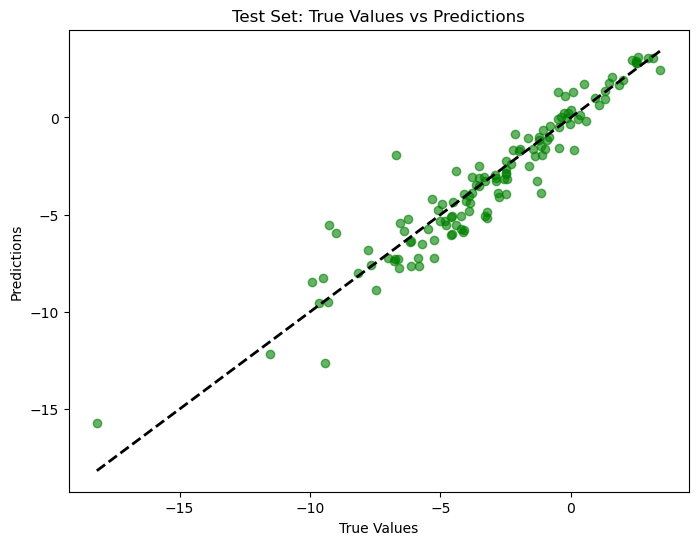

In [13]:
print("Evaluating final SWA model...")
update_bn(train_loader, swa_model)
model = swa_model

test_loss = 0
predictions = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing and Predicting"):
        inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
        labels = batch['labels'].to(device)
        outputs = model(**inputs, labels=labels)
        
        # Calculate and accumulate test loss
        loss = outputs.loss
        test_loss += loss.item()
        
        # Generate predictions
        preds = outputs.logits.squeeze().tolist()
        predictions.extend(preds)

# Average the test loss over all batches
test_loss /= len(test_loader)
print(f"Final Test Loss: {test_loss}")

# Plot predictions vs true values for test set
print("Plotting predictions vs true values...")
plt.figure(figsize=(8, 6))
plt.scatter(y_test, predictions, alpha=0.6, color='green')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Test Set: True Values vs Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.show()


In [ ]:
checkpoint_path = "model_checkpoint_{:.2f}.pth".format(test_loss)
torch.save(model, checkpoint_path)
print(f"Model checkpoint saved to {checkpoint_path}")


## Interface to Run the model on new data

In [15]:
model.load_state_dict(torch.load(checkpoint_path))
model.eval()

# Define a function to tokenize input and get prediction
def predict(smiles_string):
    # Tokenize the input SMILES string
    inputs = tokenizer(smiles_string, return_tensors="pt", padding=True, truncation=True, max_length=128)
    
    # Move inputs to the appropriate device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    # Get the model prediction
    with torch.no_grad():
        outputs = model(**inputs)
        prediction = outputs.logits.squeeze().item()
    
    return prediction

# Example usage
smiles_string = "CCO"  # Replace this with your SMILES string
prediction = predict(smiles_string)
print(f"Prediction for {smiles_string}: {prediction}")

Prediction for CCO: -5.335525035858154
